In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import scipy
from scipy.signal import filtfilt
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras

from keras.layers.core import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Embedding

# Load Data

In [ ]:
df_word=pd.read_csv("/content/drive/MyDrive/Programs/final_project/input/classes_V01.txt",sep="\t",header=None)

df_word.columns=['name','repetition','target','category']

df_word.head(2)

,name,repetition,target,category
0,"domestic cat, house cat, Felis domesticus, Fel...",24,n02121808,Mammals
1,"rock python, rock snake, Python sebae",29,n01744401,Reptile


In [ ]:
#read complete merged file
df=pd.read_csv("/content/drive/MyDrive/Programs/final_project/output/merged.csv")
df.shape

(70060, 450)

In [ ]:
df=df.iloc[:,1:]    #all data
#df=df.iloc[:100,1:]    #sample data (should be multiple of 5)
df.head(6)

,global_session_id,number_of_sessions,image_id,image_category,channels,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,t_20,t_21,t_22,t_23,t_24,t_25,t_26,t_27,t_28,t_29,t_30,t_31,t_32,t_33,t_34,t_35,...,t_405,t_406,t_407,t_408,t_409,t_410,t_411,t_412,t_413,t_414,t_415,t_416,t_417,t_418,t_419,t_420,t_421,t_422,t_423,t_424,t_425,t_426,t_427,t_428,t_429,t_430,t_431,t_432,t_433,t_434,t_435,t_436,t_437,t_438,t_439,t_440,t_441,t_442,t_443,t_444
0,2602,1,4823,n02077923,AF3,4320.000000,4332.307692,4334.871795,4342.564103,4333.333333,4313.333333,4318.974359,4349.743590,4358.974359,4335.384615,4321.025641,4333.333333,4345.641026,4334.358974,4321.025641,4320.000000,4321.538462,4320.000000,4311.794872,4309.230769,4311.282051,4301.025641,4288.205128,4291.794872,4296.923077,4290.769231,4303.076923,4337.435897,4334.358974,4298.974359,4292.307692,4305.128205,4305.641026,4305.641026,4303.589744,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2602,1,4823,n02077923,AF4,4294.871795,4305.128205,4298.974359,4307.179487,4312.307692,4284.102564,4274.871795,4314.358974,4330.769231,4324.615385,4311.282051,4275.384615,4284.615385,4322.564103,4318.461538,4285.641026,4272.820513,4307.692308,4353.333333,4341.538462,4307.179487,4307.692308,4307.692308,4304.615385,4321.538462,4312.307692,4292.307692,4298.461538,4285.641026,4278.461538,4311.282051,4318.974359,4297.435897,4301.025641,4321.538462,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2602,1,4823,n02077923,T7,4187.692308,4200.000000,4208.717949,4199.487179,4199.487179,4208.205128,4210.769231,4228.205128,4258.974359,4257.948718,4232.820513,4235.384615,4251.282051,4246.666667,4245.128205,4245.641026,4237.948718,4237.948718,4237.435897,4229.743590,4237.435897,4245.641026,4230.769231,4222.051282,4230.256410,4232.307692,4227.179487,4231.282051,4244.102564,4250.769231,4241.538462,4231.794872,4237.435897,4244.615385,4244.615385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2602,1,4823,n02077923,T8,4203.076923,4224.615385,4249.743590,4231.794872,4190.769231,4186.666667,4208.717949,4223.589744,4226.153846,4229.230769,4233.846154,4222.564103,4210.256410,4215.384615,4217.948718,4202.051282,4188.717949,4202.564103,4215.897436,4219.487179,4226.666667,4214.358974,4183.589744,4184.102564,4221.538462,4242.564103,4226.153846,4217.948718,4225.128205,4208.717949,4185.128205,4206.153846,4228.717949,4204.102564,4182.051282,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2602,1,4823,n02077923,Pz,4145.128205,4138.461538,4145.128205,4142.051282,4132.307692,4134.358974,4137.948718,4146.153846,4155.384615,4149.743590,4147.692308,4152.820513,4145.128205,4138.461538,4146.153846,4144.615385,4140.512821,4152.820513,4168.717949,4175.384615,4167.692308,4150.256410,4147.179487,4157.948718,4148.717949,4130.256410,4138.461538,4154.871795,4136.410256,4113.846154,4135.897436,4161.538462,4154.358974,4146.153846,4150.769231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2601,1,168,n02089078,AF3,4279.487179,4279.487179,4280.512821,4297.435897,4315.384615,4299.487179,4278.974359,4292.307692,4302.051282,4299.487179,4297.948718,4289.230769,4289.230769,4297.948718,4297.435897,4293.846154,4282.051282,4261.025641,4275.897436,4299.487179,4286.666667,4275.384615,4271.282051,4282.051282,4297.435897,4280.512821,4267.692308,4277.948718,4284.102564,4289.230769,4291.794872,4278.974359,4274.358974,4281.025641,4282.564103,...,NaN,NaN,NaN

In [ ]:
df.shape #check shape of all data

(70060, 449)

In [ ]:
df.isnull().sum()  #check if there are any NA values

global_session_id         0
number_of_sessions        0
image_id                  0
image_category            0
channels                  0
                      ...  
t_440                 70050
t_441                 70055
t_442                 70055
t_443                 70055
t_444                 70055
Length: 449, dtype: int64

In [ ]:
#Drop Columns which have more than 90% NAs 
df.dropna(axis=1, thresh=int(0.1 * df.shape[0]),inplace=True)
df.shape

(70060, 397)

In [ ]:
df.fillna(0, inplace=True)        #replace NaN with 0  
#df=df.ffill(axis = 1)

In [ ]:
df.isnull().sum()                   #verify there are no null values

global_session_id     0
number_of_sessions    0
image_id              0
image_category        0
channels              0
                     ..
t_388                 0
t_389                 0
t_390                 0
t_391                 0
t_392                 0
Length: 397, dtype: int64

In [ ]:
df_main=df.drop(['global_session_id',	'number_of_sessions',	'image_id',	'channels'],axis=1)

df_main.head(3)

,image_category,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,t_20,t_21,t_22,t_23,t_24,t_25,t_26,t_27,t_28,t_29,t_30,t_31,t_32,t_33,t_34,t_35,t_36,t_37,t_38,t_39,...,t_353,t_354,t_355,t_356,t_357,t_358,t_359,t_360,t_361,t_362,t_363,t_364,t_365,t_366,t_367,t_368,t_369,t_370,t_371,t_372,t_373,t_374,t_375,t_376,t_377,t_378,t_379,t_380,t_381,t_382,t_383,t_384,t_385,t_386,t_387,t_388,t_389,t_390,t_391,t_392
0,n02077923,4320.000000,4332.307692,4334.871795,4342.564103,4333.333333,4313.333333,4318.974359,4349.743590,4358.974359,4335.384615,4321.025641,4333.333333,4345.641026,4334.358974,4321.025641,4320.000000,4321.538462,4320.000000,4311.794872,4309.230769,4311.282051,4301.025641,4288.205128,4291.794872,4296.923077,4290.769231,4303.076923,4337.435897,4334.358974,4298.974359,4292.307692,4305.128205,4305.641026,4305.641026,4303.589744,4286.153846,4273.333333,4274.871795,4277.948718,...,4276.410256,4277.948718,4275.384615,4258.974359,4261.025641,4271.794872,4266.153846,4265.641026,4267.179487,4260.000000,4262.051282,4265.641026,4257.948718,4254.871795,4267.692308,4286.153846,4284.615385,4265.128205,4256.410256,4261.025641,4265.641026,4261.025641,4239.487179,4213.846154,4229.230769,4265.128205,4263.589744,4250.256410,4266.666667,4275.384615,4250.256410,4233.846154,4235.897436,4216.923077,4192.820513,4200.000000,4224.615385,4240.512821,4233.846154,4210.769231
1,n02077923,4294.871795,4305.128205,4298.974359,4307.179487,4312.307692,4284.102564,4274.871795,4314.358974,4330.769231,4324.615385,4311.282051,4275.384615,4284.615385,4322.564103,4318.461538,4285.641026,4272.820513,4307.692308,4353.333333,4341.538462,4307.179487,4307.692308,4307.692308,4304.615385,4321.538462,4312.307692,4292.307692,4298.461538,4285.641026,4278.461538,4311.282051,4318.974359,4297.435897,4301.025641,4321.538462,4325.128205,4320.000000,4294.871795,4271.282051,...,4238.461538,4242.564103,4290.769231,4284.615385,4238.974359,4250.769231,4297.948718,4325.641026,4326.666667,4294.871795,4265.128205,4254.358974,4251.282051,4272.307692,4273.846154,4240.000000,4239.487179,4269.230769,4267.692308,4254.871795,4265.128205,4272.820513,4254.358974,4223.589744,4254.358974,4302.564103,4257.948718,4215.384615,4256.410256,4264.102564,4211.794872,4210.256410,4243.589744,4232.820513,4211.282051,4222.051282,4228.717949,4213.846154,4220.000000,4246.666667
2,n02077923,4187.692308,4200.000000,4208.717949,4199.487179,4199.487179,4208.205128,4210.769231,4228.205128,4258.974359,4257.948718,4232.820513,4235.384615,4251.282051,4246.666667,4245.128205,4245.641026,4237.948718,4237.948718,4237.435897,4229.743590,4237.435897,4245.641026,4230.769231,4222.051282,4230.256410,4232.307692,4227.179487,4231.282051,4244.102564,4250.769231,4241.538462,4231.794872,4237.435897,4244.615385,4244.615385,4244.102564,4233.846154,4218.461538,4212.820513,...,4258.974359,4237.948718,4240.512821,4254.358974,4254.358974,4254.871795,4262.564103,4254.871795,4237.948718,4247.692308,4271.282051,4264.615385,4248.717949,4258.461538,4273.846154,4271.794872,4258.974359,4250.769231,4253.846154,4265.128205,4264.102564,4247.179487,4241.538462,4237.435897,4238.974359,4268.205128,4289.230769,4271.794872,4256.923077,4273.846154,4267.179487,4230.256410,4221.538462,4234.871795,4234.871795,4228.205128,4228.205128,4232.307692,4232.820513,4229.743590


In [ ]:
df_main.shape               #check shape after dropping other columns

(70060, 393)

In [ ]:
df_main.shape[0]/5

14012.0

In [ ]:
df_main.iloc[1,1:]      #view time stamps

t_1      4294.87
t_2      4305.13
t_3      4298.97
t_4      4307.18
t_5      4312.31
          ...   
t_388    4222.05
t_389    4228.72
t_390    4213.85
t_391       4220
t_392    4246.67
Name: 1, Length: 392, dtype: object

# Data Preparation
1. Merging subcategory
2. Applying filters
3. Separating  X, y

In [ ]:
#apply filters to data

def apply_bp_filter(signals,filter_type='bandpass'):

  fs= 128.0              # sample rate, Hz
  lowcut = 20.0
  highcut = 50.0

  nyq = 0.5*fs              #The Nyquist frequency is half the sampling rate
  low = lowcut / nyq
  high = highcut / nyq

  order = 2 

  if filter_type=='low':
    b, a = scipy.signal.butter(order, low, btype='low', analog=False)
  elif filter_type=='high':
    b, a = scipy.signal.butter(order, high, btype='high', analog=False)
  else:
    b,a = scipy.signal.butter(order,(low,high),'bandpass',analog=False)

  signals = scipy.signal.filtfilt(b,a,signals.T,axis=0)
  
  return pd.Series(signals.transpose())

In [ ]:
#visual representation of signals  #pass single row at a time

def display_signal(single_row):

    #print(type(single_row))
    plt.figure(figsize=(10, 1))

    #print(type(single_row))

    plt.plot(range(len(single_row)), single_row)
  
    plt.title("Signal")
    plt.ylabel('frequency')
    plt.xlabel('time')
    #plt.legend()
    plt.show()
    print("\n")

In [ ]:
# replace category with sub category

def find_and_replace(word):
  target_dict={"Animals":["Mammals","Bird","Reptile","Fish","amphibian","Asteroidea","Arthropods","arachnids","Insect"],
             "Tool":["Tool","MusicInstrument","MedicalInstrument","Stationary"],
             "Fashion":["Clothe","Cosmetics"],
             "Home_Appliances":["KitchenWare","Electronics","Furniture"],
             "Transport":["Vehicle","shipboat"],
             "Sports":["Sports"],
             "Place":["Road","Place","Airport","Event"],
             "Food":["Fruit","Food","Vegitable"],
             "Human":["Human"]            
             }
  list_list=[]
  for i in target_dict.values():
    list_list.append(i)
  for n in range(len(list_list)):
     if word in list_list[n]:
      key_index=n
  keys_list = list(target_dict)
  key = keys_list[key_index]
  return key

In [ ]:
#Data preparation : filtering, creating batches of 5 signals

def prepare_data(data_frame,num_channels,unit_test=False):

  signals_list=[]
  signals_cat=[]
  n=num_channels #number ofchannels 

  for i in range(0,data_frame.shape[0],num_channels):
    
    #print("i=",i, "\n",df_main[i:i+n])                 #info

    channels_list=[]

    df_batch=df_main[i:i+n]

    class_label=df_batch.loc[i][0]
    

    sub_class_label=df_word.loc[df_word['target']==class_label,'category'].to_list()[0]

    sub_class_label=find_and_replace(sub_class_label)      #sub_class level 2

    
    

    #print(df_batch.loc[i][0])                          #info
    #print(df_batch.iloc[:,1:])                         #info

    for i, row in df_batch.iloc[:,1:].iterrows():

        if unit_test: display_signal(row)                            #display signal before filter

        row=apply_bp_filter(row)                        #apply bandpass filter
        
        row=apply_bp_filter(row,'low')                  #apply low pass filter

        row=apply_bp_filter(row,'high')

        if unit_test: display_signal(row)                            #display signal after filter

        row_ls = row.values.tolist()                    # create a list of values from dataframe row

        #print("lenght= ",len(row_ls))                  #info
        #print(row_ls)                                  #info
        
        signals_list.append(row_ls)                    #append row list to signals list
        signals_cat.append(sub_class_label)
    
    #signals_list.extend(channels_list) 

  return signals_list,signals_cat

In [ ]:
#get sample data unit test : set of five channels 
df_sample=df_main.iloc[:10,:].copy()
df_sample

,image_category,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,t_20,t_21,t_22,t_23,t_24,t_25,t_26,t_27,t_28,t_29,t_30,t_31,t_32,t_33,t_34,t_35,t_36,t_37,t_38,t_39,...,t_353,t_354,t_355,t_356,t_357,t_358,t_359,t_360,t_361,t_362,t_363,t_364,t_365,t_366,t_367,t_368,t_369,t_370,t_371,t_372,t_373,t_374,t_375,t_376,t_377,t_378,t_379,t_380,t_381,t_382,t_383,t_384,t_385,t_386,t_387,t_388,t_389,t_390,t_391,t_392
0,n02077923,4320.000000,4332.307692,4334.871795,4342.564103,4333.333333,4313.333333,4318.974359,4349.743590,4358.974359,4335.384615,4321.025641,4333.333333,4345.641026,4334.358974,4321.025641,4320.000000,4321.538462,4320.000000,4311.794872,4309.230769,4311.282051,4301.025641,4288.205128,4291.794872,4296.923077,4290.769231,4303.076923,4337.435897,4334.358974,4298.974359,4292.307692,4305.128205,4305.641026,4305.641026,4303.589744,4286.153846,4273.333333,4274.871795,4277.948718,...,4276.410256,4277.948718,4275.384615,4258.974359,4261.025641,4271.794872,4266.153846,4265.641026,4267.179487,4260.000000,4262.051282,4265.641026,4257.948718,4254.871795,4267.692308,4286.153846,4284.615385,4265.128205,4256.410256,4261.025641,4265.641026,4261.025641,4239.487179,4213.846154,4229.230769,4265.128205,4263.589744,4250.256410,4266.666667,4275.384615,4250.256410,4233.846154,4235.897436,4216.923077,4192.820513,4200.000000,4224.615385,4240.512821,4233.846154,4210.769231
1,n02077923,4294.871795,4305.128205,4298.974359,4307.179487,4312.307692,4284.102564,4274.871795,4314.358974,4330.769231,4324.615385,4311.282051,4275.384615,4284.615385,4322.564103,4318.461538,4285.641026,4272.820513,4307.692308,4353.333333,4341.538462,4307.179487,4307.692308,4307.692308,4304.615385,4321.538462,4312.307692,4292.307692,4298.461538,4285.641026,4278.461538,4311.282051,4318.974359,4297.435897,4301.025641,4321.538462,4325.128205,4320.000000,4294.871795,4271.282051,...,4238.461538,4242.564103,4290.769231,4284.615385,4238.974359,4250.769231,4297.948718,4325.641026,4326.666667,4294.871795,4265.128205,4254.358974,4251.282051,4272.307692,4273.846154,4240.000000,4239.487179,4269.230769,4267.692308,4254.871795,4265.128205,4272.820513,4254.358974,4223.589744,4254.358974,4302.564103,4257.948718,4215.384615,4256.410256,4264.102564,4211.794872,4210.256410,4243.589744,4232.820513,4211.282051,4222.051282,4228.717949,4213.846154,4220.000000,4246.666667
2,n02077923,4187.692308,4200.000000,4208.717949,4199.487179,4199.487179,4208.205128,4210.769231,4228.205128,4258.974359,4257.948718,4232.820513,4235.384615,4251.282051,4246.666667,4245.128205,4245.641026,4237.948718,4237.948718,4237.435897,4229.743590,4237.435897,4245.641026,4230.769231,4222.051282,4230.256410,4232.307692,4227.179487,4231.282051,4244.102564,4250.769231,4241.538462,4231.794872,4237.435897,4244.615385,4244.615385,4244.102564,4233.846154,4218.461538,4212.820513,...,4258.974359,4237.948718,4240.512821,4254.358974,4254.358974,4254.871795,4262.564103,4254.871795,4237.948718,4247.692308,4271.282051,4264.615385,4248.717949,4258.461538,4273.846154,4271.794872,4258.974359,4250.769231,4253.846154,4265.128205,4264.102564,4247.179487,4241.538462,4237.435897,4238.974359,4268.205128,4289.230769,4271.794872,4256.923077,4273.846154,4267.179487,4230.256410,4221.538462,4234.871795,4234.871795,4228.205128,4228.205128,4232.307692,4232.820513,4229.743590
3,n02077923,4203.076923,4224.615385,4249.743590,4231.794872,4190.769231,4186.666667,4208.717949,4223.589744,4226.153846,4229.230769,4233.846154,4222.564103,4210.256410,4215.384615,4217.948718,4202.051282,4188.717949,4202.564103,4215.897436,4219.487179,4226.666667,4214.358974,4183.589744,4184.102564,4221.538462,4242.564103,4226.153846,4217.948718,4225.128205,4208.717949,4185.128205,4206.153846,4228.717949,4204.102564,4182.051282,4194.871795,4202.564103,4197.435897,4203.076923,...,4202.564103,4213.333333,4215.897436,4193.846154,4193.333333,4217.948718,4225.128205,4218.974359,4207.692308,4191.794872,4205.128205,4207.179487,4166.666667,4169.230769,4227.69230

In [ ]:
df_sample.shape

(10, 393)

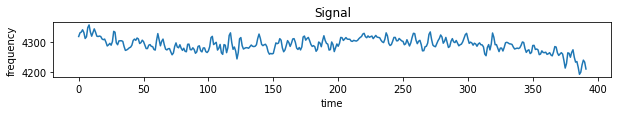

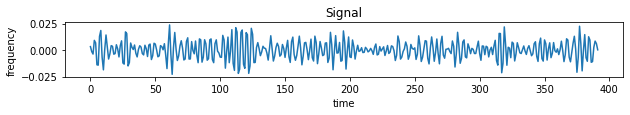

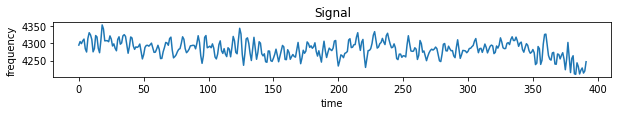

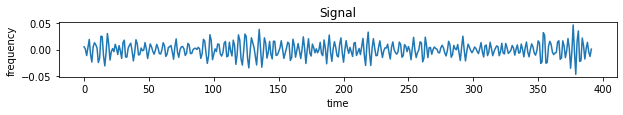

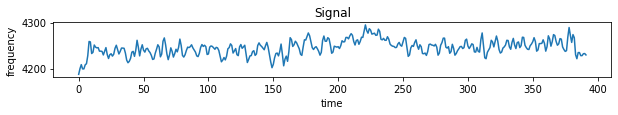

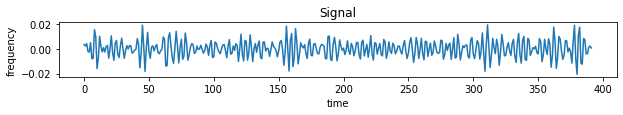

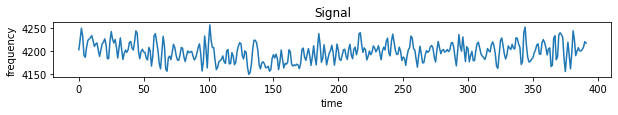

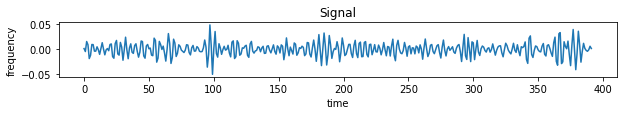

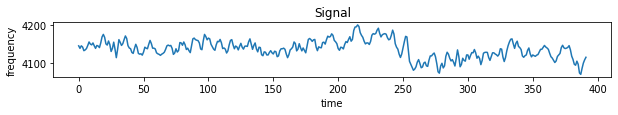

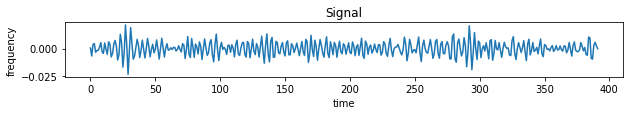

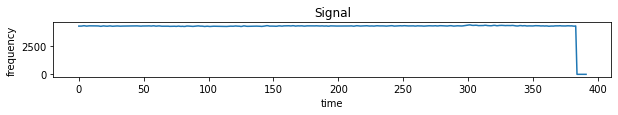

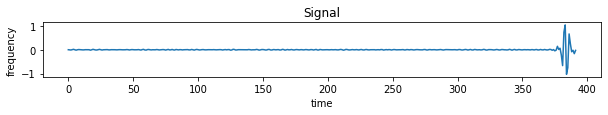

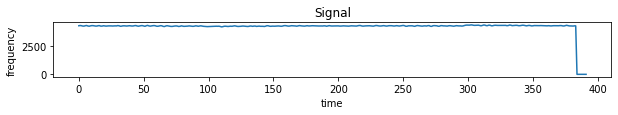

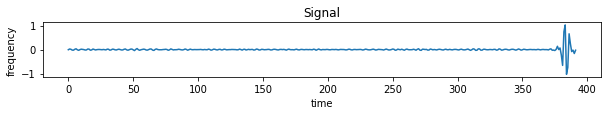

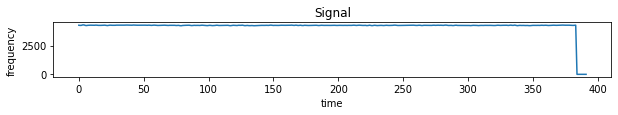

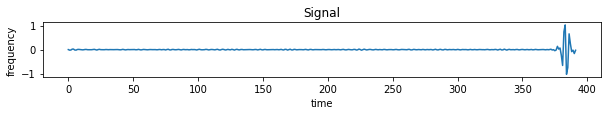

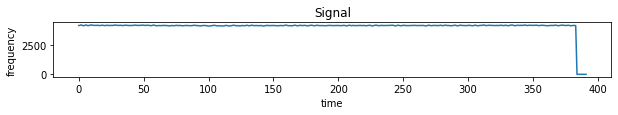

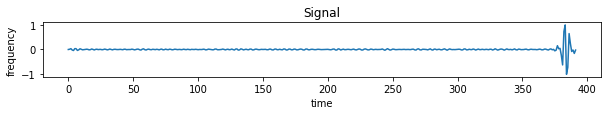

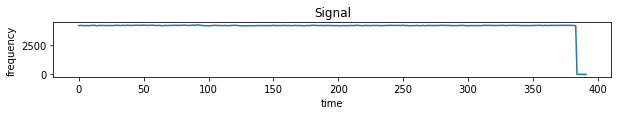

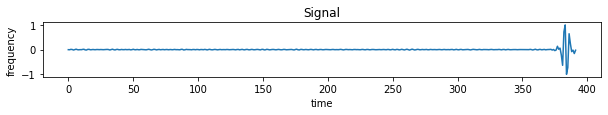

In [ ]:
#check sample data (5 signals): before and after filtering
x_sample,y_sample = prepare_data(df_sample,1,unit_test=True) 

In [ ]:
len(x_sample)

10

In [ ]:
print(x_sample)

[[0.003340646422917158, -0.0013345061191356684, -0.0036715109903271027, 0.00923915340825349, 0.006862109939662969, -0.013778663925186032, -0.014109127177142754, 0.013023838855561133, 0.018533542942043665, -0.006669963762625348, -0.018527992480851723, 0.0004964346916402299, 0.014294237824555385, 0.002565266655282096, -0.008335233600435896, -0.0034574645355653867, 0.004287513871713227, 0.003618153291230783, -0.0037859667990707184, -0.0032389424233621456, 0.005091323871583728, 0.0011894324853074425, -0.006366609328268834, 0.004171917271093093, 0.008780482878335587, -0.012036649483158132, -0.013127778907840892, 0.01721220982907859, 0.015645423332123428, -0.014856552392655565, -0.011720284172884541, 0.006740194526408335, 0.002672854777490551, 0.0005929307123109673, 0.004841005642051678, -0.002865571259577054, -0.006361458238180642, 0.0006928344806655783, 0.004169245591733968, 0.002895639685038931, -0.003193455129641892, -0.004443599175305766, 0.004629811395817686, 0.0014294968772722845, -0.

# Prepare data X, y

In [ ]:
#get final data for model : X, y
X,y = prepare_data(df_main,1)

X= np.array(X)   #convert X to numpy array

le = LabelEncoder()
y = le.fit_transform(y)                                 #for ML models
yy = tf.keras.utils.to_categorical(le.fit_transform(y)) #for cateorical problems/DNN

# Resampling : X, y

In [ ]:
orig_shape = X.shape

#take backup copy
X_orig=X.copy()
y_orig=y.copy()

orig_shape  #original shape of X

(70060, 392)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import collections, numpy

#function to print count  of classes
def print_counter(y_data):
  counter = Counter(y)
  for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
  #plot the distribution of classes
  plt.bar(counter.keys(), counter.values())
  plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Class=0, n=38675 (55.203%)
Class=2, n=3190 (4.553%)
Class=5, n=2695 (3.847%)
Class=7, n=5045 (7.201%)
Class=3, n=8565 (12.225%)
Class=8, n=5895 (8.414%)
Class=6, n=2905 (4.146%)
Class=4, n=745 (1.063%)
Class=1, n=2345 (3.347%)


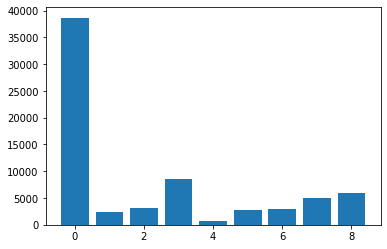

In [ ]:
print_counter(y) #original y distribution

In [ ]:

count_class=collections.Counter(y)
print(count_class) #occurances of all classes
count_class[0] #number of occurances of class 0

Counter({0: 38675, 3: 8565, 8: 5895, 7: 5045, 2: 3190, 6: 2905, 5: 2695, 1: 2345, 4: 745})


38675

In [ ]:
int(count_class[0]*25/100)  #retain 25% of data from 0 with 0 class

9668

### undersampling majority class

Class=0, n=9668 (23.550%)
Class=1, n=2345 (5.712%)
Class=2, n=3190 (7.770%)
Class=3, n=8565 (20.863%)
Class=4, n=745 (1.815%)
Class=5, n=2695 (6.565%)
Class=6, n=2905 (7.076%)
Class=7, n=5045 (12.289%)
Class=8, n=5895 (14.359%)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


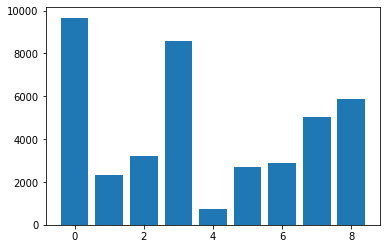

In [ ]:
from imblearn.under_sampling import RandomUnderSampler


rus = RandomUnderSampler({0:int(count_class[0]*25/100)},random_state=0)
rus.fit(X, y)
X, y = rus.fit_resample(X, y)


print_counter(y)

### oversampling minority class

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Class=0, n=9668 (11.111%)
Class=1, n=9668 (11.111%)
Class=2, n=9668 (11.111%)
Class=3, n=9668 (11.111%)
Class=4, n=9668 (11.111%)
Class=5, n=9668 (11.111%)
Class=6, n=9668 (11.111%)
Class=7, n=9668 (11.111%)
Class=8, n=9668 (11.111%)


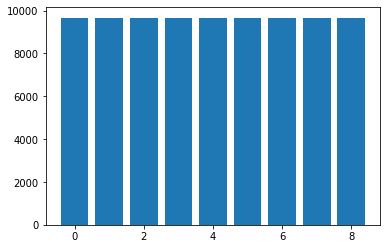

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
ros.fit(X, y)
X, y = ros.fit_resample(X, y)

print_counter(y)

# After sampling X, y

In [ ]:
X=X 
y=y
yy = tf.keras.utils.to_categorical(le.fit_transform(y)) #for cateorical problems/DNN

In [ ]:
X.shape, y.shape, yy.shape

((87012, 392), (87012,), (87012, 9))

In [ ]:
type(X), type(y), type(yy)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [ ]:
len(X[1])

392

In [ ]:
y[:6]

array([0, 0, 0, 0, 0, 0])

In [ ]:
yy[:7]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
#shuffle data
idx = np.random.permutation(len(X))
X_nn = X[idx]
y_nn = yy[idx]                  #for simple caegorical problem
y_ml = y[idx]                   #for ML models

In [ ]:
X_nn.shape, y_nn.shape, y_ml.shape

((87012, 392), (87012, 9), (87012,))

In [ ]:
num_labels = len(np.unique(y_ml))
num_labels

9

In [ ]:
#plot accuracies
def plot_accuracy(history, plot_type="accuracy"):
  if plot_type=="categorical_accuracy":
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
  else:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
  
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  print("\n")

#plot loss graph
def plot_loss(history):
  plt.plot(history.history['loss']) 
  plt.plot(history.history['val_loss']) 
  plt.title('Model loss') 
  plt.ylabel('Loss') 
  plt.xlabel('Epoch') 
  plt.legend(['Train', 'Test'], loc='upper left') 
  plt.show()
  print("\n")

# ML Models

In [ ]:

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#y_nn for categorical

X_train, X_test, y_train, y_test = train_test_split(X_nn,y_ml, test_size=0.3, random_state = 2021,shuffle=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60908, 392), (26104, 392), (60908,), (26104,))

# 1. Logistic regression

In [ ]:
#only logistic regeression

model_lr = LogisticRegression()
model_lr.fit(X_train,y_train)

y_pred = model_lr.predict(X_test)

#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))
print("Accuracy = ",accuracy_score(y_test, y_pred))

Accuracy =  0.15576156910818265


# 2. Bagging Classifier

In [ ]:
# Default

#Default

model_bg = BaggingClassifier(random_state=2021,oob_score=True,
                             max_features=X_train.shape[1],
                             n_estimators=15,
                             max_samples=X_train.shape[0])

model_bg.fit( X_train , y_train )

print("Out of Bag Score = " + "{:.4f}".format(model_bg.oob_score_))

y_pred = model_bg.predict(X_test)

#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))
print("Accuracy = ", accuracy_score(y_test, y_pred))

Out of Bag Score = 0.7078
Accuracy =  0.7324931045050567


In [ ]:
#bagging with logistic regression

logreg = LogisticRegression()

model_bg = BaggingClassifier(base_estimator = logreg ,
                             random_state=2021,oob_score=True,
                             max_features=X_train.shape[1],
                             n_estimators=15,max_samples=X_train.shape[0])
                             
model_bg.fit( X_train , y_train )

print("Out of Bag Score = " + "{:.4f}".format(model_bg.oob_score_))

y_pred = model_bg.predict(X_test)

#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))
print("Accuracy = ",accuracy_score(y_test, y_pred))

Out of Bag Score = 0.1631
Accuracy =  0.1598605577689243


# 3. Decision Tree

In [ ]:
# descision tree : default

model_dt = DecisionTreeClassifier(max_depth=4,
                             min_samples_leaf=10,
                             random_state=2021)
model_dt.fit(X_train,y_train)

y_pred = model_dt.predict(X_test)

#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))
print("Accuracy = ", accuracy_score(y_test,y_pred))

Accuracy =  0.12634079068342016


In [ ]:
# decision tree : tunning 

depth_range = [3,4,5] #,6,7,8,9]
minsplit_range = [5,10]#,20,25,30]
minleaf_range = [5,10,15]

parameters = dict(max_depth=depth_range,
                  min_samples_split=minsplit_range, 
                  min_samples_leaf=minleaf_range)



kfold = StratifiedKFold(n_splits=5, random_state=2020,shuffle=True)



clf = DecisionTreeClassifier(random_state=2021)
cv = GridSearchCV(clf, param_grid=parameters,
                  cv=kfold,scoring='roc_auc_ovr')

cv.fit(X,y)

# Viewing all parameter sets
df_cv = pd.DataFrame(cv.cv_results_)

# Best Parameters
print("best params = ",cv.best_params_)

print("best score = ",cv.best_score_)

best_model = cv.best_estimator_

best_model.fit(X_train,y_train)

y_pred = best_model.predict(X_test)


#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))
print("Accuracy = ", accuracy_score(y_test,y_pred))

best params =  {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5}
best score =  0.5330781404876506
Accuracy =  0.136569108182654


# 4. XG Boost

In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier(random_state=2021)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print("Accuracy = ", accuracy_score(y_test,y_pred))

Accuracy =  0.32768924302788843
